In [1]:
import os
import sys
import glob
import random
import numpy as np
import pandas as pd
import scipy.ndimage
from PIL import Image
import matplotlib.pyplot as plt 
from matplotlib.pyplot import imshow
from IPython.display import display, HTML
from sklearn.metrics import accuracy_score

from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50

import numpy as np
% matplotlib inline


# Import modules every time you run code imported using %aimport
%load_ext autoreload
%autoreload 1

# Add the src directory for functions
src_dir = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'src')
print(src_dir)
sys.path.append(src_dir)

# import my functions:
%aimport models
from models import*
%aimport functions
from functions import*

# Base Directory where data is stored
base_data_dir = '/home/rbbidart/project/rbbidart/breakHis/'
base_out_dir = '/home/rbbidart/breakHis_out'

Using TensorFlow backend.


/home/rbbidart/breakHis/src


## Load and Save models
* Compute nodes have no internet
* resnet50, inception resnet v2

In [5]:
# InceptionV3 = InceptionV3(weights='imagenet', include_top=False)
# InceptionV3.save('/Users/rb/Downloads/InceptionV3')

# ResNet50 = ResNet50(weights='imagenet', include_top=False)
# ResNet50.save('/Users/rb/Downloads/ResNet50')

## InceptionV3
* Add dense layer and train this
* Straight from keras tutorial

In [4]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.engine.topology import Layer
from keras.layers import Dropout, Flatten, Reshape, Input
from keras.layers.core import Activation, Dense, Lambda
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import SGD 

def ft_pre_model(base_model, data_loc, out_loc, magnification, num_out, epochs_first=10, img_dim=512, layer_train=249):   
    # Params
    epochs_first=int(epochs_first)
    batch_size=16   # make this divisible by len(x_data)
    img_dim=int(img_dim)
    layer_train = int(layer_train)
    
    # Paths to data
    if not os.path.exists(out_loc):
        os.makedirs(out_loc)
    train_loc = os.path.join(str(data_loc), str(magnification), 'train')
    valid_loc = os.path.join(str(data_loc), str(magnification), 'valid')
    num_train = len(glob.glob(train_loc + '/**/*.png', recursive=True))
    num_valid = len(glob.glob(valid_loc + '/**/*.png', recursive=True))
    print('num_train', num_train)
    print('num_valid', num_valid)

    # Set the number of steps per epoch
    steps_per_epoch = np.floor(num_train/batch_size) # num of batches from generator at each epoch. (make it full train set)
    validation_steps = np.floor(num_valid/batch_size)# size of validation dataset divided by batch size
    print('steps_per_epoch', steps_per_epoch)
    print('validation_steps', validation_steps)

    # Image generators
    datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.1,
        height_shift_range=.2,
        width_shift_range=.2,
        rotation_range=360,
        horizontal_flip=True,
        vertical_flip=True)

    generator = datagen.flow_from_directory(
            train_loc,
            target_size=(img_dim, img_dim),
            batch_size=batch_size,
            class_mode='categorical')

    valid_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input)

    valid_generator = valid_datagen.flow_from_directory(
            valid_loc,
            target_size=(img_dim, img_dim),
            batch_size=batch_size,
            class_mode='categorical')

    # train the last layers first. We don't need this to be perfect, just get resonable weights before fine tuning
    # add a global spatial average pooling layer for visualization
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_out, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    print('Training the top layers only')
    hist = model.fit_generator(generator,
                                  validation_data=valid_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=epochs_first,
                                  validation_steps=validation_steps)

    print('Make sure nothing is going terribly wrong with training last layers')
    print('Final 2 Epochs Avg Validation loss: ', np.mean(hist.history['val_acc'][-2:]))


    plt.plot(hist.history['loss'])    
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('Training top layers')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Train acc', 'val_acc'], loc='upper left')
    plt.figure(figsize=(10,6))
    plt.show()
    
    # at this point, the top layers are well trained and we can start fine-tuning convolutional layers 
    # We will freeze the bottom N layers and train the remaining top layers.
    for layer in model.layers[:layer_train]:
       layer.trainable = False
    for layer in model.layers[layer_train:]:
       layer.trainable = True

    # we need to recompile the model for these modifications to take effect
    # we use SGD with a low learning rate
    model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

    # we train our model again (this time fine-tuning the top 2 inception blocks
    # alongside the top Dense layers
    print('Fine tuning layers')
    callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=0),
                 ModelCheckpoint(filepath=os.path.join(out_loc, 'fine_tune'+'_.{epoch:02d}-{val_acc:.2f}.hdf5'), 
                                 verbose=1, monitor='val_loss', save_best_only=True)]

    hist = model.fit_generator(generator,
                                  validation_data=valid_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=100,
                                  validation_steps=validation_steps,
                                  callbacks=callbacks)

    print('Check fine-tuning')
    print('Final 5 Epochs Avg Validation loss: ', np.mean(hist.history['val_acc'][-5:]))
    plt.plot(hist.history['loss'])    
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('Fine tuning model')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Train acc', 'val_acc'], loc='upper left')
    plt.figure(figsize=(10,6))
    plt.show()

In [5]:
# for i, layer in enumerate(base_model.layers):
#    print(i, layer.name)

/home/rbbidart/tensorflow/lib/python3.5/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


num_train 1078
num_valid 243
steps_per_epoch 67.0
validation_steps 15.0
Found 1078 images belonging to 8 classes.
Found 243 images belonging to 8 classes.
Training the top layers only
Epoch 1/5
68/67 [==============================] - 145s 2s/step - loss: 1.7988 - acc: 0.3836 - val_loss: 1.3826 - val_acc: 0.6626
Epoch 2/5
68/67 [==============================] - 73s 1s/step - loss: 1.5854 - acc: 0.4497 - val_loss: 1.1700 - val_acc: 0.6626
Epoch 3/5
68/67 [==============================] - 75s 1s/step - loss: 1.4799 - acc: 0.4738 - val_loss: 1.1103 - val_acc: 0.6502
Epoch 4/5
68/67 [==============================] - 68s 1s/step - loss: 1.3767 - acc: 0.5021 - val_loss: 0.9869 - val_acc: 0.6872
Epoch 5/5
68/67 [==============================] - 72s 1s/step - loss: 1.3002 - acc: 0.5399 - val_loss: 0.9197 - val_acc: 0.7243
Make sure nothing is going terribly wrong with training last layers
Final 2 Epochs Avg Validation loss:  0.705761316934


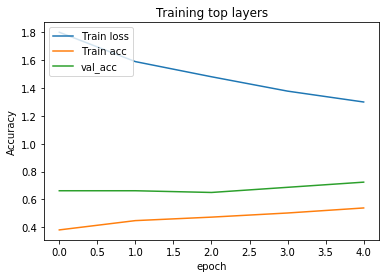

Fine tuning layers
Epoch 1/100
68/67 [==============================] - 92s 1s/step - loss: 1.2387 - acc: 0.5502 - val_loss: 0.9707 - val_acc: 0.7202
Epoch 2/100
68/67 [==============================] - 69s 1s/step - loss: 1.1484 - acc: 0.6035 - val_loss: 0.9735 - val_acc: 0.7284
Epoch 3/100
68/67 [==============================] - 75s 1s/step - loss: 1.1130 - acc: 0.6278 - val_loss: 0.9632 - val_acc: 0.7325
Epoch 4/100
68/67 [==============================] - 74s 1s/step - loss: 1.0874 - acc: 0.6374 - val_loss: 0.9411 - val_acc: 0.7449
Epoch 5/100
68/67 [==============================] - 81s 1s/step - loss: 1.0556 - acc: 0.6603 - val_loss: 0.9408 - val_acc: 0.7449
Epoch 6/100
68/67 [==============================] - 71s 1s/step - loss: 1.0524 - acc: 0.6572 - val_loss: 0.9389 - val_acc: 0.7490
Epoch 7/100
68/67 [==============================] - 81s 1s/step - loss: 1.0285 - acc: 0.6583 - val_loss: 0.9309 - val_acc: 0.7407
Epoch 8/100
68/67 [==============================] - 78s 1s/step

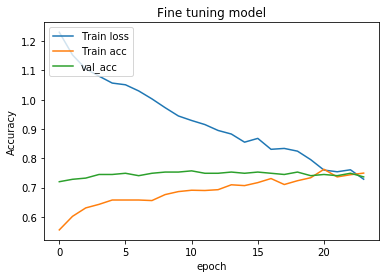

In [7]:
base_model = load_model('/home/rbbidart/project/rbbidart/InceptionV3')
data_loc = os.path.join(base_data_dir, 'mkfold_keras_8', 'fold1')
out_loc = os.path.join(base_out_dir, 'inception_pre_249')
num_out = 8
magnification = 100

ft_pre_model(base_model, data_loc, out_loc, magnification, num_out, epochs_first=5, 
                          img_dim=512, layer_train=249)

#### Fine-tuning more layers 
* Do 4 inception blocks instead of 2

/home/rbbidart/tensorflow/lib/python3.5/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


num_train 1078
num_valid 243
steps_per_epoch 67.0
validation_steps 15.0
Found 1078 images belonging to 8 classes.
Found 243 images belonging to 8 classes.
Training the top layers only
Epoch 1/10
68/67 [==============================] - 84s 1s/step - loss: 1.7721 - acc: 0.4162 - val_loss: 1.6009 - val_acc: 0.4156
Epoch 2/10
68/67 [==============================] - 68s 1s/step - loss: 1.5645 - acc: 0.4559 - val_loss: 1.1796 - val_acc: 0.6626
Epoch 3/10
68/67 [==============================] - 78s 1s/step - loss: 1.4770 - acc: 0.4620 - val_loss: 1.0994 - val_acc: 0.6626
Epoch 4/10
68/67 [==============================] - 75s 1s/step - loss: 1.3615 - acc: 0.5068 - val_loss: 1.0115 - val_acc: 0.6667
Epoch 5/10
68/67 [==============================] - 75s 1s/step - loss: 1.3290 - acc: 0.5244 - val_loss: 1.1184 - val_acc: 0.6749
Epoch 6/10
68/67 [==============================] - 68s 1s/step - loss: 1.2335 - acc: 0.5650 - val_loss: 1.0132 - val_acc: 0.7078
Epoch 7/10
68/67 [==================

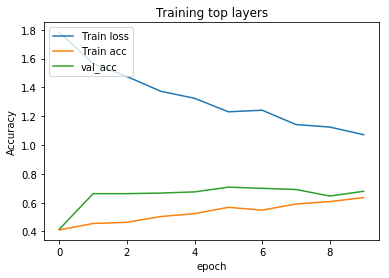

Fine tuning layers
Epoch 1/100
68/67 [==============================] - 105s 2s/step - loss: 1.0186 - acc: 0.6461 - val_loss: 0.9330 - val_acc: 0.7119
Epoch 2/100
68/67 [==============================] - 75s 1s/step - loss: 0.9259 - acc: 0.6860 - val_loss: 0.9303 - val_acc: 0.7202
Epoch 3/100
68/67 [==============================] - 79s 1s/step - loss: 0.8721 - acc: 0.7125 - val_loss: 0.9132 - val_acc: 0.7366
Epoch 4/100
68/67 [==============================] - 85s 1s/step - loss: 0.8378 - acc: 0.7087 - val_loss: 0.9040 - val_acc: 0.7366
Epoch 5/100
68/67 [==============================] - 76s 1s/step - loss: 0.8279 - acc: 0.7182 - val_loss: 0.8920 - val_acc: 0.7366
Epoch 6/100
68/67 [==============================] - 85s 1s/step - loss: 0.7934 - acc: 0.7320 - val_loss: 0.8818 - val_acc: 0.7366
Epoch 7/100
68/67 [==============================] - 75s 1s/step - loss: 0.7744 - acc: 0.7328 - val_loss: 0.8701 - val_acc: 0.7449
Epoch 8/100
68/67 [==============================] - 83s 1s/ste

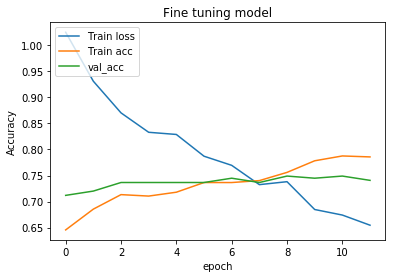

In [8]:
base_model = load_model('/home/rbbidart/project/rbbidart/InceptionV3')
data_loc = os.path.join(base_data_dir, 'mkfold_keras_8', 'fold1')
out_loc = os.path.join(base_out_dir, 'inception_pre_197')
num_out = 8
magnification = 100

ft_pre_model(base_model, data_loc, out_loc, magnification, num_out, epochs_first=10, 
                          img_dim=512, layer_train=197)

## Resnet
* Train the last two blocks of 16 total

/home/rbbidart/tensorflow/lib/python3.5/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


num_train 1078
num_valid 243
steps_per_epoch 67.0
validation_steps 15.0
Found 1078 images belonging to 8 classes.
Found 243 images belonging to 8 classes.
Training the top layers only
Epoch 1/10
68/67 [==============================] - 84s 1s/step - loss: 1.4638 - acc: 0.4907 - val_loss: 1.1755 - val_acc: 0.6955
Epoch 2/10
68/67 [==============================] - 68s 994ms/step - loss: 0.9609 - acc: 0.6618 - val_loss: 0.9065 - val_acc: 0.7613
Epoch 3/10
68/67 [==============================] - 71s 1s/step - loss: 0.7174 - acc: 0.7514 - val_loss: 0.9522 - val_acc: 0.7984
Epoch 4/10
68/67 [==============================] - 71s 1s/step - loss: 0.6505 - acc: 0.7672 - val_loss: 1.0332 - val_acc: 0.7037
Epoch 5/10
68/67 [==============================] - 71s 1s/step - loss: 0.5662 - acc: 0.8041 - val_loss: 1.0119 - val_acc: 0.7778
Epoch 6/10
68/67 [==============================] - 71s 1s/step - loss: 0.5451 - acc: 0.8184 - val_loss: 1.1640 - val_acc: 0.6667
Epoch 7/10
68/67 [===============

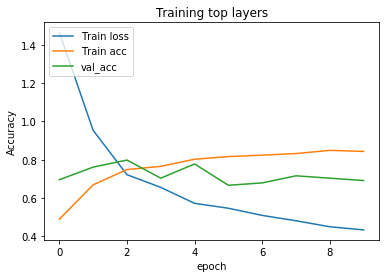

Fine tuning layers
Epoch 1/100
68/67 [==============================] - 93s 1s/step - loss: 0.3850 - acc: 0.8748 - val_loss: 1.1690 - val_acc: 0.6955
Epoch 2/100
68/67 [==============================] - 69s 1s/step - loss: 0.3609 - acc: 0.8890 - val_loss: 1.1540 - val_acc: 0.6914
Epoch 3/100
68/67 [==============================] - 72s 1s/step - loss: 0.3000 - acc: 0.9080 - val_loss: 1.1576 - val_acc: 0.6914
Epoch 4/100
68/67 [==============================] - 73s 1s/step - loss: 0.3427 - acc: 0.8896 - val_loss: 1.1789 - val_acc: 0.6872
Epoch 5/100
68/67 [==============================] - 73s 1s/step - loss: 0.3211 - acc: 0.9083 - val_loss: 1.1668 - val_acc: 0.6831
Epoch 6/100
68/67 [==============================] - 73s 1s/step - loss: 0.3083 - acc: 0.9080 - val_loss: 1.1732 - val_acc: 0.6831
Epoch 7/100
68/67 [==============================] - 73s 1s/step - loss: 0.3129 - acc: 0.9006 - val_loss: 1.1687 - val_acc: 0.6872
Check fine-tuning
Final 5 Epochs Avg Validation loss:  0.6864197

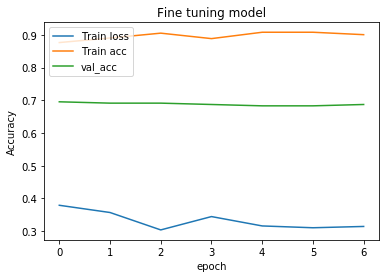

In [9]:
base_model = load_model('/home/rbbidart/project/rbbidart/ResNet50')
data_loc = os.path.join(base_data_dir, 'mkfold_keras_8', 'fold1')
out_loc = os.path.join(base_out_dir, 'ResNet50_pre_152')
num_out = 8
magnification = 100

ft_pre_model(base_model, data_loc, out_loc, magnification, num_out, epochs_first=10, 
                          img_dim=512, layer_train=152)

#### Fine-tuning more layers 
* Train the last 6 blocks of 16 total

In [ ]:
base_model = load_model('/home/rbbidart/project/rbbidart/ResNet50')
data_loc = os.path.join(base_data_dir, 'mkfold_keras_8', 'fold1')
out_loc = os.path.join(base_out_dir, 'ResNet50_pre_110')
num_out = 8
magnification = 100

finetune_pretrained_model(base_model, data_loc, out_loc, magnification, num_out, epochs_first=10, 
                          img_dim=512, layer_train=110)

# Visualize Stuff

# Don't accidentally add an unnecessary fully connected layer

/home/rbbidart/tensorflow/lib/python3.5/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


num_train 1078
num_valid 243
steps_per_epoch 67.0
validation_steps 15.0
Found 1078 images belonging to 8 classes.
Found 243 images belonging to 8 classes.
Training the top layers only
Epoch 1/5
68/67 [==============================] - 150s 2s/step - loss: 1.8091 - acc: 0.3976 - val_loss: 1.3868 - val_acc: 0.6626
Epoch 2/5
68/67 [==============================] - 73s 1s/step - loss: 1.5917 - acc: 0.4288 - val_loss: 1.2977 - val_acc: 0.6584
Epoch 3/5
68/67 [==============================] - 68s 1s/step - loss: 1.4900 - acc: 0.4776 - val_loss: 1.1240 - val_acc: 0.6749
Epoch 4/5
68/67 [==============================] - 71s 1s/step - loss: 1.3921 - acc: 0.5006 - val_loss: 1.0669 - val_acc: 0.7490
Epoch 5/5
68/67 [==============================] - 71s 1s/step - loss: 1.3030 - acc: 0.5403 - val_loss: 1.1591 - val_acc: 0.6790
Make sure nothing is going terribly wrong with training last layers
Final 2 Epochs Avg Validation loss:  0.71399176967


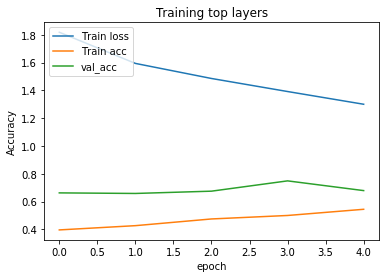

Fine tuning layers
Epoch 1/100
68/67 [==============================] - 99s 1s/step - loss: 1.1658 - acc: 0.6045 - val_loss: 0.9736 - val_acc: 0.7490
Epoch 2/100
68/67 [==============================] - 74s 1s/step - loss: 1.1251 - acc: 0.6286 - val_loss: 0.9577 - val_acc: 0.7654
Epoch 3/100
68/67 [==============================] - 78s 1s/step - loss: 1.0754 - acc: 0.6497 - val_loss: 0.9261 - val_acc: 0.7613
Epoch 4/100
68/67 [==============================] - 78s 1s/step - loss: 1.0442 - acc: 0.6658 - val_loss: 0.9081 - val_acc: 0.7778
Epoch 5/100
68/67 [==============================] - 78s 1s/step - loss: 1.0078 - acc: 0.6682 - val_loss: 0.9012 - val_acc: 0.7737
Epoch 6/100
68/67 [==============================] - 78s 1s/step - loss: 0.9703 - acc: 0.6833 - val_loss: 0.8801 - val_acc: 0.7819
Epoch 7/100
68/67 [==============================] - 78s 1s/step - loss: 0.9349 - acc: 0.6875 - val_loss: 0.8766 - val_acc: 0.7737
Epoch 8/100
68/67 [==============================] - 79s 1s/step

KeyboardInterrupt: 

In [3]:
base_model = load_model('/home/rbbidart/project/rbbidart/InceptionV3')
data_loc = os.path.join(base_data_dir, 'mkfold_keras_8', 'fold1')
out_loc = os.path.join(base_out_dir, 'inception_pre_197_simple')
num_out = 8
magnification = 100

ft_pre_model_simple(base_model, data_loc, out_loc, magnification, num_out, epochs_first=5, 
                          img_dim=512, layer_train=197)

In [69]:
import scipy.ndimage

def visualize_incp(model, img_loc):
    image_shape = (512, 512)
    img = Image.open(img_loc)
    img = np.array(img.resize(image_shape))
    
    get_output = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[3].output])
    
    class_weights = model.layers[-1].get_weights()[0]

    pred_model = Model(inputs=model.input, outputs=model.get_layer(index=-1).output)
    cov_model = Model(inputs=model.input, outputs=model.get_layer(index=310).output)
     
    predictions = pred_model.predict(np.expand_dims(img, axis=0))
    conv_outputs = cov_model.predict(np.expand_dims(img, axis=0))
    conv_outputs = conv_outputs[0, :, :, :]
        
    cam = np.zeros(dtype = np.float32, shape = [conv_outputs.shape[0], conv_outputs.shape[0], class_weights.shape[1]])
    heat_img = np.zeros(dtype = np.float32, shape = [conv_outputs.shape[0], conv_outputs.shape[0], class_weights.shape[1]])

    print('conv_outputs.shape', conv_outputs.shape)
    print('class_weights.shape', class_weights.shape)
    print('cam.shape', cam.shape)

    
    #Create the class activation map.
    # Convert final conv layer from features (2048 dim) to predictions (8)
    # Already learned mapping after global average pooling, so just appply it to every spatial location
    
    for target_class in range(class_weights.shape[1]):
        for i, w in enumerate(class_weights[:, target_class]):
            cam[:, :, target_class] += w * conv_outputs[:, :, i]
            
    zoom_factor=image_shape[0]/cam.shape[0]
    cam = scipy.ndimage.zoom(cam, (zoom_factor, zoom_factor, 1), order=2)
    # Normalize it to 255
    #cam = cam-np.amin(cam)
    cam=cam-np.mean(cam)
    cam = 255*(cam/np.amax(cam))
    
    print('np.mean(cam)', np.mean(cam))
    print('np.mean(img)', np.mean(img))

    
    for i in range(2):
        heat_img = img
        heat_img[:, :, 0] = cam[:, :, i]*0.5

        plt.imshow(heat_img)
        plt.figure(figsize=(10,6))
        plt.show()

    
#     plt.imshow(cam[1, :, :])
#     plt.figure(figsize=(10,6))
#     plt.show()
    
#     plt.imshow(cam[2, :, :])
#     plt.figure(figsize=(10,6))
#     plt.show()
    
#     plt.figure(figsize=(10,6))
#     plt.imshow(img)
#     plt.show()


conv_outputs.shape (14, 14, 2048)
class_weights.shape (2048, 8)
cam.shape (14, 14, 8)
np.mean(cam) -4.78327e-06
np.mean(img) 207.639719645


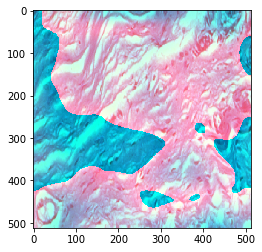

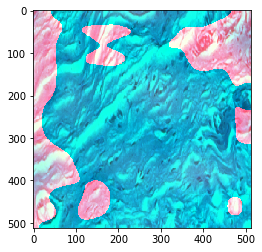

In [70]:
model_loc = os.path.join(base_out_dir, 'inception_pre_249', 'fine_tune_.19-0.75.hdf5')
# model = load_model(model_loc)

# img_loc = '/home/rbbidart/project/rbbidart/breakHis/mkfold_keras_8/fold1/100/valid/B_F/SOB_B_F-14-14134-100-001.png'
img_loc = '/home/rbbidart/project/rbbidart/breakHis/mkfold_keras_8/fold1/100/valid/B_F/SOB_B_F-14-14134-100-021.png'

visualize_incp(model, img_loc)

In [15]:
def visualize_incp_clean(model, img_loc):
    image_shape = (512, 512)
    
    img = Image.open(img_loc)
    img = np.array(img.resize(image_shape))
    
    class_weights = model.layers[-1].get_weights()[0]

    # Load the model an extra 2 times. Super dumb but I cant handle the batchnorm training error
    pred_model = Model(inputs=model.input, outputs=model.get_layer(index=-1).output)
    cov_model = Model(inputs=model.input, outputs=model.get_layer(index=310).output)
     
    predictions = pred_model.predict(np.expand_dims(img, axis=0))
    conv_outputs = cov_model.predict(np.expand_dims(img, axis=0))
    
    # Remove unncessary dim:
    conv_outputs = conv_outputs[0, :, :, :]
        
    print('conv_outputs.shape', conv_outputs.shape)
    print('class_weights.shape', class_weights.shape)
    
    #Create the class activation map
    cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])
    target_class = 1
    
    cam = class_weights[:, target_class] * conv_outputs[:, :, :]
    
    print('cam.shape', cam.shape )
    plt.imshow(cam[0, :, :])
    plt.figure(figsize=(10,6))
    plt.show()
    
    plt.imshow(cam[1, :, :])
    plt.figure(figsize=(10,6))
    plt.show()
    
    plt.imshow(cam[2, :, :])
    plt.figure(figsize=(10,6))
    plt.show()

conv_outputs.shape (14, 14, 2048)
class_weights.shape (2048, 8)
cam.shape (14, 14, 2048)


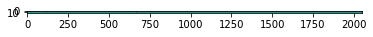

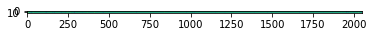

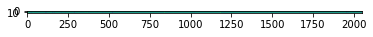

In [17]:
visualize_incp_clean(model, img_loc)